# Synthetic Data Evaluation 2023-05

## Load Packages

In [1]:
from pathlib import Path
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.compose import make_column_transformer

import lightgbm as lgb
from lightgbm import early_stopping

import warnings
warnings.simplefilter(action="ignore", category=UserWarning)

## Define Datasets

In [19]:
repo = './data/'
#repo = 'https://github.com/mostly-ai/paper-fidelity-accuracy/raw/main/2023-05/data/'

# list of datasets to benchmark
datasets = [
    'adult',
    'credit-default',
    'bank-marketing', 
    'online-shoppers',
]

# list of synthesizers to benchmark
fns = [
    'mostly', 
    'gretel',
    'copulagan', 
    'ctgan', 
    'tvae', 
    'gaussian_copula', 
    'synthpop',
]

# Fidelity Metrics

In [20]:
def bin_data(dt1, dt2, c = 10):
    dt1 = dt1.copy()
    dt2 = dt2.copy()
    # quantile binning of numerics
    num_cols = dt1.select_dtypes(include='number').columns
    for col in num_cols:
        # determine breaks based on `dt1`
        breaks = dt1[col].quantile(np.linspace(0, 1, c+1)).unique()
        dt1[col] = pd.cut(dt1[col], bins=breaks, include_lowest=True).astype(str)
        dt2_vals = pd.to_numeric(dt2[col], 'coerce')
        dt2_bins = pd.cut(dt2_vals, bins=breaks, include_lowest=True).astype(str)
        dt2_bins[dt2_vals < min(breaks)] = '_other_'
        dt2_bins[dt2_vals > max(breaks)] = '_other_'
        dt2[col] = dt2_bins
    # # convert bools to categoricals
    bool_cols = dt1.select_dtypes(include=['bool'])
    for col in bool_cols:
        dt1[col] = dt1[col].astype('str')
        dt2[col] = dt2[col].astype('str')
    # top-C binning of categoricals
    cat_cols = dt1.select_dtypes(include=['object', 'category', 'string'])
    for col in cat_cols:
        # determine top values based on `dt1`
        top_vals = dt1[col].value_counts().head(c).index.tolist()
        dt1[col].replace(np.setdiff1d(dt1[col].unique().tolist(), top_vals), '_other_', inplace=True)
        dt2[col].replace(np.setdiff1d(dt2[col].unique().tolist(), top_vals), '_other_', inplace=True)
    return [dt1, dt2]

def hellinger(p1, p2):
  return np.sqrt(1 - np.sum(np.sqrt(p1*p2)))

def kullback_leibler(p1, p2):
  idx = p1>0
  return np.sum(p1[idx] * np.log(p1[idx]/p2[idx]))

def jensen_shannon(p1, p2):
  m = 0.5 * (p1 + p2)
  return 0.5 * kullback_leibler(p1, m) + 0.5 * kullback_leibler(p2, m)

def fidelity(dt1, dt2, c = 100, k = 1):
    [dt1_bin, dt2_bin] = bin_data(dt1, dt2, c = c)
    # build grid of all cross-combinations
    cols = trn.columns
    interactions = pd.DataFrame(np.array(np.meshgrid(cols, cols, cols)).reshape(3, len(cols)**3).T)
    interactions.columns = ['dim1', 'dim2', 'dim3']
    if k == 1:
        interactions = interactions.loc[(interactions['dim1']==interactions['dim2']) & (interactions['dim2']==interactions['dim3'])]
    elif k == 2:
        interactions = interactions.loc[(interactions['dim1']<interactions['dim2']) & (interactions['dim2']==interactions['dim3'])]
    elif k == 3:
        interactions = interactions.loc[(interactions['dim1']<interactions['dim2']) & (interactions['dim2']<interactions['dim3'])]
        # interactions = interactions.sample(n=min(1_000, len(interactions)))
    else:
        raise('k>3 not supported')

    results = []
    for idx in range(interactions.shape[0]):
        row = interactions.iloc[idx]
        val1 = dt1_bin[row.dim1] + dt1_bin[row.dim2] + dt1_bin[row.dim3]
        val2 = dt2_bin[row.dim1] + dt2_bin[row.dim2] + dt2_bin[row.dim3]
        freq1 = val1.value_counts(normalize=True).to_frame(name='p1')
        freq2 = val2.value_counts(normalize=True).to_frame(name='p2')
        freq = freq1.join(freq2, how='outer').fillna(0.0)
        p1 = freq['p1']
        p2 = freq['p2']
        out = pd.DataFrame({
          'k': f"{k=}",
          'dim1': [row.dim1], 
          'dim2': [row.dim2], 
          'dim3': [row.dim3],
          'tvd': [np.sum(np.abs(p1 - p2)) / 2], 
          'mae': [np.mean(np.abs(p1 - p2))], 
          'max': [np.max(np.abs(p1 - p2))],
          'l1d': [np.sum(np.abs(p1 - p2))],
          'l2d': [np.sqrt(np.sum((p1 - p2)**2))],
          'hellinger': [hellinger(p1, p2)],
          'jensen_shannon': [jensen_shannon(p1, p2)]
        })
        results.append(out)

    return pd.concat(results)

In [29]:
%%time 

fid = []
for dataset in datasets:
    trn_fn = f"{repo}{dataset}_trn.csv.gz"
    trn = pd.read_csv(trn_fn)
    print(f"read {trn_fn} {trn.shape}")
    for fn in fns + ['val']:
        if dataset == "online-shoppers" and fn == "copulagan":
            print('skipping online-shoppers copulagan (no data available)')
            pass 
        else:
            syn_fn = f"{repo}{dataset}_{fn}.csv.gz"
            syn = pd.read_csv(syn_fn)
            print(f"read {syn_fn} {syn.shape}")
            # 1-way marginal distributions (=univariates)
            fid1 = fidelity(trn, syn, k=1, c=100)
            print('calculate 1-way fidelity')
            # 2-way marginal distributions (=bivariates)
            fid2 = fidelity(trn, syn, k=2, c=10)
            print('calculate 2-way fidelity')
            # 3-way marginal distributions; these are compute-intensive
            fid3 = fidelity(trn, syn, k=3, c=5)
            print('calculate 3-way fidelity')
            out = pd.concat([fid1, fid2, fid3])
            out['dataset'] = dataset
            out['synthesizer'] = fn if fn!='val' else 'HOLDOUT'
            fid.append(out)

fid = pd.concat(fid)
fid.to_csv('fidelity.csv', index=False)

read ./data/adult_trn.csv.gz (24421, 15)
read ./data/adult_mostly.csv.gz (24421, 15)
calculate 1-way fidelity
calculate 2-way fidelity
calculate 3-way fidelity
read ./data/adult_gretel.csv.gz (50000, 15)
calculate 1-way fidelity
calculate 2-way fidelity
calculate 3-way fidelity
read ./data/adult_copulagan.csv.gz (50000, 15)
calculate 1-way fidelity
calculate 2-way fidelity
calculate 3-way fidelity
read ./data/adult_ctgan.csv.gz (50000, 15)
calculate 1-way fidelity
calculate 2-way fidelity
calculate 3-way fidelity
read ./data/adult_tvae.csv.gz (50000, 15)
calculate 1-way fidelity
calculate 2-way fidelity
calculate 3-way fidelity
read ./data/adult_gaussian_copula.csv.gz (50000, 15)
calculate 1-way fidelity
calculate 2-way fidelity
calculate 3-way fidelity
read ./data/adult_synthpop.csv.gz (50000, 15)
calculate 1-way fidelity
calculate 2-way fidelity
calculate 3-way fidelity
read ./data/adult_val.csv.gz (24421, 15)
calculate 1-way fidelity
calculate 2-way fidelity
calculate 3-way fidelity

In [22]:
fid.head()

,k,dim1,dim2,dim3,tvd,mae,max,l1d,l2d,hellinger,jensen_shannon,dataset,synthesizer
0,k=1,age,age,age,0.031530,0.001236,0.007453,0.063060,0.012376,0.031354,0.000982,adult,mostly
0,k=1,workclass,workclass,workclass,0.013063,0.002613,0.012080,0.026125,0.014389,0.017460,0.000261,adult,mostly
0,k=1,fnlwgt,fnlwgt,fnlwgt,0.036813,0.000736,0.002539,0.073625,0.009352,0.032938,0.001084,adult,mostly
0,k=1,education,education,education,0.017239,0.002155,0.007412,0.034479,0.012521,0.016760,0.000281,adult,mostly
0,k=1,education-num,education-num,education-num,0.017239,0.002463,0.007412,0.034479,0.012579,0.016753,0.000281,adult,mostly


In [23]:
# calculate average 
agg = fid.groupby(['dataset', 'synthesizer', 'k'])['tvd'].mean().to_frame().reset_index()
# convert to wide format
agg = agg.pivot_table(index=['dataset', 'synthesizer'], columns=['k'], values='tvd').reset_index(['dataset', 'synthesizer'])
agg = agg.sort_values(['dataset', 'k=1']).reset_index(drop=True)
agg.columns.name = None
agg

,dataset,synthesizer,k=1,k=2,k=3
0,adult,synthpop,0.006496,0.012617,0.018545
1,adult,HOLDOUT,0.010002,0.015557,0.020895
2,adult,mostly,0.014018,0.020647,0.026737
3,adult,gretel,0.046493,0.076097,0.099353
4,adult,tvae,0.072322,0.107016,0.128678
5,adult,ctgan,0.101039,0.131407,0.149206
6,adult,copulagan,0.118265,0.152169,0.174868
7,adult,gaussian_copula,0.196744,0.268682,0.330292
8,bank-marketing,synthpop,0.006345,0.010916,0.014396
9,bank-marketing,HOLDOUT,0.009657,0.013252,0.017443


In [24]:
def plot(agg, dataset, metric, title):
    d = agg.loc[agg['dataset']==dataset]
    p = d.plot(kind='barh', x='synthesizer', y=metric, title=f"{title} - {dataset}")
    p.axvline(d.loc[d.synthesizer=='HOLDOUT', metric].to_numpy()[0], color='black')


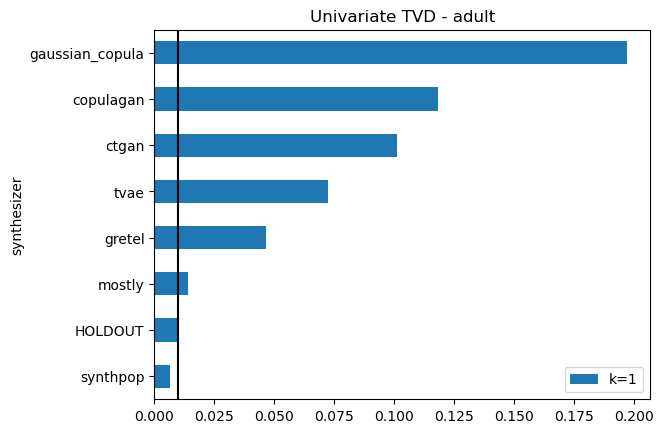

In [25]:
plot(agg, 'adult', 'k=1', 'Univariate TVD')

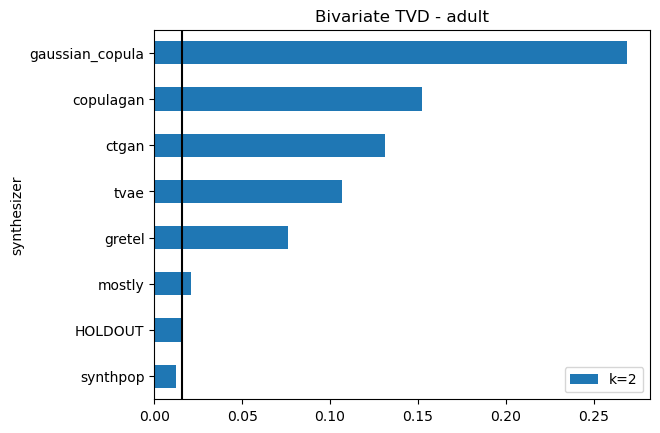

In [26]:
plot(agg, 'adult', 'k=2', 'Bivariate TVD')

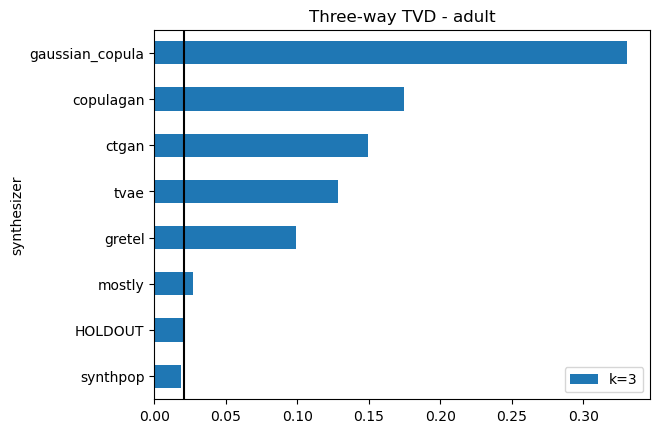

In [27]:
plot(agg, 'adult', 'k=3', 'Three-way TVD')

# Machine Learning Utility

In [28]:
dataset = 'adult'

if dataset == 'adult':
    target_col = 'income'
    target_val = '>50K'
elif dataset == 'bank-marketing':
    target_col = 'y'
    target_val = 'yes'
elif dataset == 'credit-default':
    target_col = 'default payment next month'
    target_val = 1
elif dataset == 'online-shoppers':
    target_col = 'Revenue'
    target_val = 'True'

def prepare_xy(df):
    y = (df[target_col]==target_val).astype(int)
    str_cols = [col for col in df.select_dtypes(['object', 'string']).columns if col != target_col]
    for col in str_cols:
        df[col] = pd.Categorical(df[col])
    cat_cols = [col for col in df.select_dtypes('category').columns if col != target_col]
    num_cols = [col for col in df.select_dtypes('number').columns if col != target_col]
    for col in num_cols:
        df[col] = df[col].astype('float')
    X = df[cat_cols + num_cols]
    return X, y

def train_model(X, y):
    cat_cols = list(X.select_dtypes('category').columns)
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    ds_trn = lgb.Dataset(X_trn, label=y_trn, categorical_feature=cat_cols, free_raw_data=False)
    ds_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols, free_raw_data=False)
    model = lgb.train(
        params={
            'verbose': -1,
            'metric': 'auc',  
            'objective': 'binary'
        }, 
        train_set=ds_trn,
        valid_sets=[ds_val],
        callbacks=[early_stopping(5)],
    )
    return model

def evaluate_model(model, hol):
    X_hol, y_hol = prepare_xy(hol)
    probs = model.predict(X_hol)
    preds = (probs >= 0.5).astype(int)
    auc = roc_auc_score(y_hol, probs)
    acc = accuracy_score(y_hol, preds)
    out = pd.DataFrame({
          'auc': [auc],
          'acc': [acc], 
        })
    return out

In [ ]:
# fns = sorted(list(Path('data/').glob('*.csv.gz')))
# for fn in fns:
#     print(fn)
#     df = pd.read_csv(fn)
#     df = df.drop(columns='Unnamed: 0', errors='ignore')
#     df.to_csv(fn, index=False)

In [ ]:
val_fn = f"{repo}{dataset}_val.csv.gz"
val = pd.read_csv(val_fn)
print(f"read {val_fn} {val.shape}")
results = []
for fn in fns + ['trn']:
    syn_fn = f"{repo}{dataset}_{fn}.csv.gz"
    syn = pd.read_csv(syn_fn)
    print(f"read {syn_fn} {syn.shape}")
    X, y = prepare_xy(syn)
    m = train_model(X, y)
    row = evaluate_model(m, val)
    row = row.assign(synthesizer=fn if fn!='trn' else 'ORIGINAL')
    row = row.assign(dataset=dataset)
    results.append(row)

ml = pd.concat(results).sort_values('auc', ascending=False)

In [ ]:
ml

In [ ]:
def plot(agg, dataset, metric, title):
    d = agg.loc[agg['dataset']==dataset]
    p = d.plot(kind='scatter', x='synthesizer', y=metric, title=f"{title} - {dataset}", s=100)
    p.axhline(d.loc[d.synthesizer=='ORIGINAL', metric].to_numpy()[0], color='black')

In [ ]:
plot(ml, 'adult', 'auc', 'ML Performance - Holdout AUC')

# Privacy Metrics

In [ ]:
def priv(trn, val, syn):
    n_trn = trn.shape[0]
    n_val = val.shape[0]
    max_syn = 2_000  # cap to keep compute reasonable
    n_syn = min(max_syn, syn.shape[0])
    syn = syn[:n_syn]
    print(f"{n_trn=}, {n_val=}, {n_syn=}")
    numeric_cols = trn.select_dtypes(include=np.number).columns
    other_cols = trn.select_dtypes(exclude=np.number).columns
    transformer = make_column_transformer(
        (OneHotEncoder(), other_cols),
        (QuantileTransformer(output_distribution='normal'), numeric_cols),
        remainder="passthrough",
    )
    transformer.fit(pd.concat([trn, val, syn], axis=0))
    trn_hot = transformer.transform(trn)
    val_hot = transformer.transform(val)
    syn_hot = transformer.transform(syn)
    print('calculate distances to training data')
    index = NearestNeighbors(n_neighbors=1, algorithm="brute", metric="l2", n_jobs=-1)
    index.fit(trn_hot)
    dcrs_trn, idxs_trn = index.kneighbors(syn_hot)
    print('calculate distances to holdout data')
    index = NearestNeighbors(n_neighbors=1, algorithm="brute", metric="l2", n_jobs=-1)
    index.fit(val_hot)
    dcrs_val, idxs_val = index.kneighbors(syn_hot)
    # normalize
    dcrs_trn = np.square(dcrs_trn)[:,0]/2
    dcrs_val = np.square(dcrs_val)[:,0]/2
    # results
    share = np.mean(dcrs_trn<dcrs_val) + (n_trn/(n_trn+n_val)) * np.mean(dcrs_trn==dcrs_val)
    ratio = np.maximum(dcrs_trn, 1e-20) / np.maximum(dcrs_val, 1e-20)
    out = pd.DataFrame({
        'n_syn': [n_syn],
        'n_closer': np.sum([dcrs_trn<dcrs_val]),
        'n_further': np.sum([dcrs_trn>dcrs_val]),
        'n_equal': np.sum([dcrs_trn==dcrs_val]),
        'share': [share],
        'ratio_q50': np.median(ratio),
        'Avg DCR to Training': [np.mean(dcrs_trn)],
        'Avg DCR to Holdout': [np.mean(dcrs_val)],
    })
    return out

out = []
for dataset in datasets:
    trn_fn = f"{repo}{dataset}_trn.csv.gz"
    trn = pd.read_csv(trn_fn)
    print(f"read {trn_fn} {trn.shape}")
    val_fn = f"{repo}{dataset}_val.csv.gz"
    val = pd.read_csv(val_fn)
    print(f"read {val_fn} {val.shape}")
    for fn in fns:
        syn_fn = f"{repo}{dataset}_{fn}.csv.gz"
        syn = pd.read_csv(syn_fn)
        print(f"read {syn_fn} {syn.shape}")
        pri = priv(trn, val, syn)
        pri['dataset'] = dataset
        pri['synthesizer'] = fn
        out.append(pri)
            
priv = pd.concat(out).sort_values(["dataset", "synthesizer"])
priv